
# **Inteligencia arificial con redes pre-entrenadas**

¿Alguna vez te has preguntado cómo las computadoras pueden "ver" y analizar imágenes como nosotros? En este taller, te introduciremos al fascinante mundo de la visión por computadora. Utilizaremos una red neuronal llamada Inception v3, que es como un experto en reconocer patrones en imágenes.

Imagina que tenemos miles de fotos de ojos sanos y con diferentes enfermedades. Con Inception v3, enseñaremos a la computadora a identificar las características únicas de cada enfermedad, como si estuviera aprendiendo a distinguir entre una manzana y una naranja. Al final de este taller, serás capaz de entender cómo una máquina puede ayudar a los médicos a diagnosticar enfermedades oculares de manera más rápida y precisa. ¡No necesitas conocimientos previos en programación o inteligencia artificial!

Datos: https://www.kaggle.com/datasets/gunavenkatdoddi/preprocessed-eye-diseases-fundus-images

## Red convolucional INCEPTION V3


Inception v3 es una arquitectura de red neuronal convolucional (CNN) que se utiliza para el reconocimiento de imágenes. Es la tercera versión de Inception CNN de Google y es conocida por el uso de nuevos procedimientos como convoluciones factorizadas 7x7, RMSProp Optimizer, Label Smoothing y BatchNorm en los clasificadores auxiliares.

Inception v3 es un modelo previamente entrenado que puede clasificar imágenes en 1000 categorías de objetos, como animales, teclados, ratones y lápices. Ha sido entrenado con más de un millón de imágenes de la base de datos ImageNet y tiene un tamaño de entrada de imagen de 299 por 299. Inception v3 se utiliza a menudo como arquitectura base y para transferencia de aprendizaje en estudios de investigación.

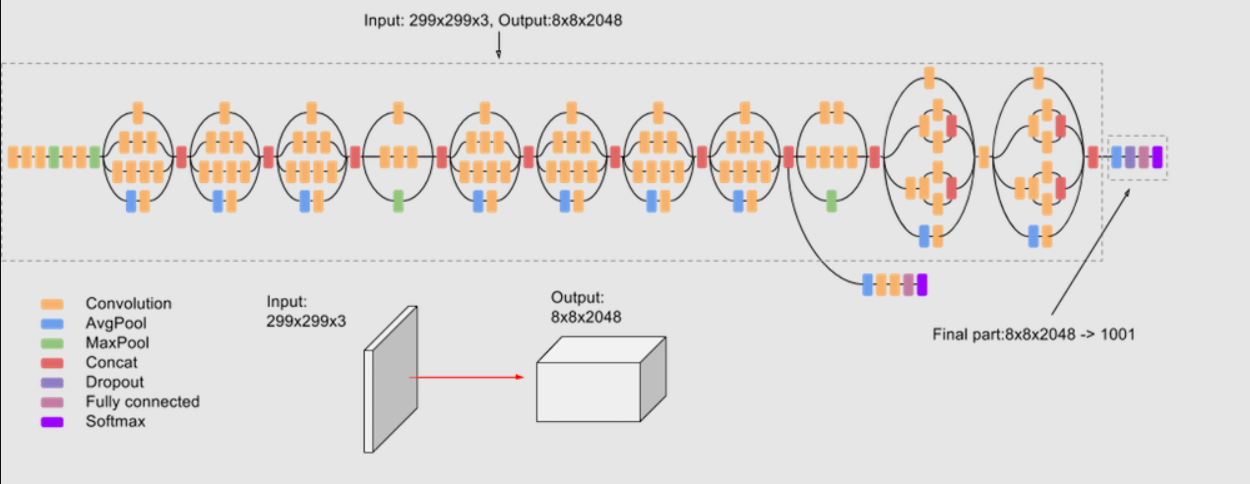

In [3]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00


# IMPORTACIONES DE LIBRERÍAS

In [4]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
from keras import backend as K
from keras import applications
from tensorflow.keras.utils import plot_model

#import keras_tuner as kt

from sklearn.metrics import classification_report, confusion_matrix

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.15.0


# Bajando el dataset de ojos con enfermedades y sanos

In [5]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d gunavenkatdoddi/preprocessed-eye-diseases-fundus-images


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/preprocessed-eye-diseases-fundus-images
License(s): ODbL-1.0
 94% 442M/472M [00:01<00:00, 209MB/s]
100% 472M/472M [00:02<00:00, 245MB/s]


In [6]:
! unzip preprocessed-eye-diseases-fundus-images.zip

Archive:  preprocessed-eye-diseases-fundus-images.zip
  inflating: seg_dataset/cataract/0_left.jpg  
  inflating: seg_dataset/cataract/103_left.jpg  
  inflating: seg_dataset/cataract/1062_right.jpg  
  inflating: seg_dataset/cataract/1083_left.jpg  
  inflating: seg_dataset/cataract/1084_right.jpg  
  inflating: seg_dataset/cataract/1102_left.jpg  
  inflating: seg_dataset/cataract/1102_right.jpg  
  inflating: seg_dataset/cataract/1115_left.jpg  
  inflating: seg_dataset/cataract/1126_right.jpg  
  inflating: seg_dataset/cataract/112_right.jpg  
  inflating: seg_dataset/cataract/1144_left.jpg  
  inflating: seg_dataset/cataract/1144_right.jpg  
  inflating: seg_dataset/cataract/1164_left.jpg  
  inflating: seg_dataset/cataract/1167_right.jpg  
  inflating: seg_dataset/cataract/119_left.jpg  
  inflating: seg_dataset/cataract/1285_left.jpg  
  inflating: seg_dataset/cataract/1415_left.jpg  
  inflating: seg_dataset/cataract/1415_right.jpg  
  inflating: seg_dataset/cataract/1435_left.

In [8]:
# tamaño de lote 32 fotos, tamaño de imagen 224 x 224 pixeles
batch_size = 32
img_height = 224
img_width = 224

In [9]:
# Dividiendo el grupo de training
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/seg_dataset',
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4217 files belonging to 4 classes.
Using 3374 files for training.


In [10]:
# Dividiendo el grupo de validación
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/seg_dataset',
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4217 files belonging to 4 classes.
Using 843 files for validation.


In [11]:
# Se encontraron 4217 fotos que pertenecen a 4 clases, de las cuales se utilizan 843 fotos para validar
class_names = train_ds.class_names
print(class_names)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


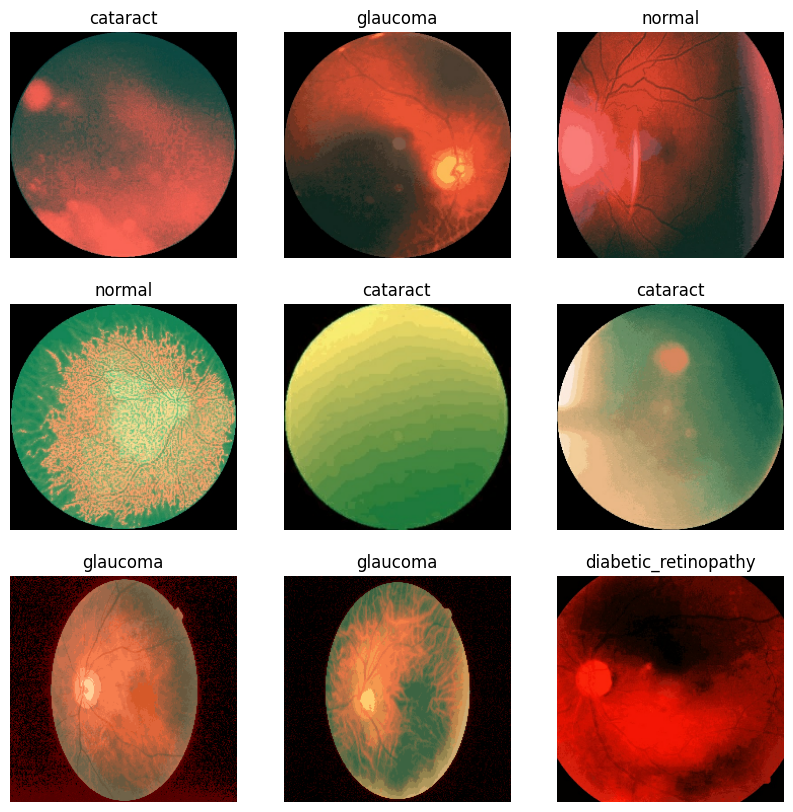

In [12]:
# Graficar 9 fotos
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        print(images[i].numpy().shape)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

# INCEPTIONV3

Hacemos la primera prueba con el modelo inception v3, para identificar las 4 clases Ojo normal, Glaucoma, Carataras y Retinopatía diabética

## Modelo base

In [13]:
# se llama el modelo base y se imprime la estructura
base_model = InceptionV3(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights="imagenet",
)

base_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

## Al modelo base le articulamos una salida de las 4 clases que queremos reconocer

In [14]:
# Se hace el entrenamiento de la última parte

clf = Sequential(name='eye_disease')

clf.add(base_model)
clf.add(GlobalAveragePooling2D(name='Pooling'))
clf.add(Dense(50, activation="relu", name='Dense_1'))
clf.add(Dense(10, activation="relu", name='Dense_2'))
clf.add(Dense(len(class_names), activation="softmax", name='Dense_out'))

clf.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["acc",tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

#clf.summary()

In [ ]:
# Parar cuando el recall no cambie en 3 corridas
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=3, mode='max')
]

## Entrenamiento del modelo

In [ ]:
# Entrenando el modelo
with tf.device('/device:GPU:0'):
    history = clf.fit(train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=my_callbacks
    )

Epoch 1/50
106/106 [==============================] - 153s 1s/step - loss: 0.7087 - acc: 0.7220 - precision: 0.8069 - recall: 0.6269 - val_loss: 21.5522 - val_acc: 0.2847 - val_precision: 0.2847 - val_recall: 0.2847
Epoch 2/50
106/106 [==============================] - 131s 1s/step - loss: 0.4469 - acc: 0.8239 - precision: 0.8488 - recall: 0.7937 - val_loss: 0.9796 - val_acc: 0.7924 - val_precision: 0.7955 - val_recall: 0.7888
Epoch 3/50
106/106 [==============================] - 128s 1s/step - loss: 0.3565 - acc: 0.8678 - precision: 0.8794 - recall: 0.8518 - val_loss: 7.4150 - val_acc: 0.4389 - val_precision: 0.4388 - val_recall: 0.4377
Epoch 4/50
106/106 [==============================] - 128s 1s/step - loss: 0.3119 - acc: 0.8814 - precision: 0.8898 - recall: 0.8708 - val_loss: 1.2057 - val_acc: 0.6987 - val_precision: 0.7169 - val_recall: 0.6940
Epoch 5/50
106/106 [==============================] - 128s 1s/step - loss: 0.3296 - acc: 0.8699 - precision: 0.8817 - recall: 0.8589 - val_

## Prediciendo imágenes

In [ ]:
y_true = list()
y_pred = list()

for images, labels in train_ds:
    pred = clf.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

1/1 [==============================] - 1s 1s/step


(array([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]], dtype=float32),
 array([[0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        ...,
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]]))

## Métricas del modelo

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

                      precision    recall  f1-score   support

            cataract       0.50      1.00      0.67       836
diabetic_retinopathy       1.00      0.96      0.98       884
            glaucoma       0.97      0.23      0.37       802
              normal       0.69      0.54      0.61       852

           micro avg       0.69      0.69      0.69      3374
           macro avg       0.79      0.68      0.66      3374
        weighted avg       0.79      0.69      0.66      3374
         samples avg       0.69      0.69      0.69      3374



1/1 [==============================] - 0s 260ms/step


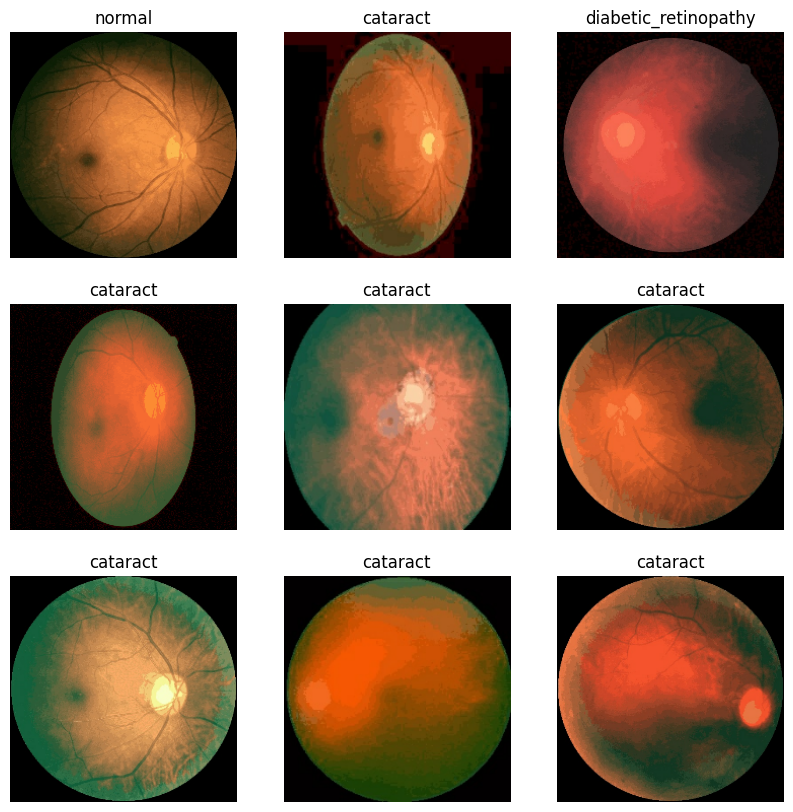

In [ ]:
plt.figure(figsize=(10, 10))

df = train_ds.take(1)

for images, labels in df:
    pred = clf.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

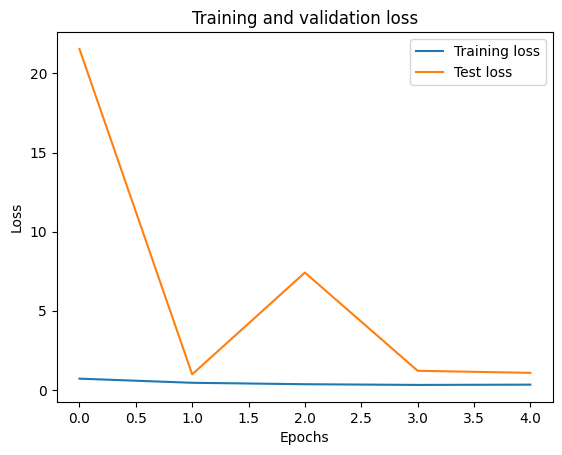

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

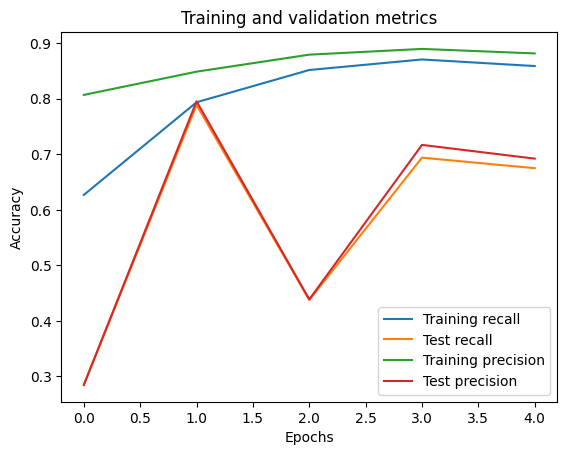

In [ ]:
plt.plot(history.history['recall'], label='Training recall')
plt.plot(history.history['val_recall'], label='Test recall')
plt.plot(history.history['precision'], label='Training precision')
plt.plot(history.history['val_precision'], label='Test precision')
plt.title('Training and validation metrics')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_true = list()
y_pred = list()

for images, labels in val_ds:
    pred = clf.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

1/1 [==============================] - 0s 134ms/step


(array([[0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]], dtype=float32),
 array([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        ...,
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 0, 0, 1]]))

# Prediciendo con el modelo

1/1 [==============================] - 0s 227ms/step


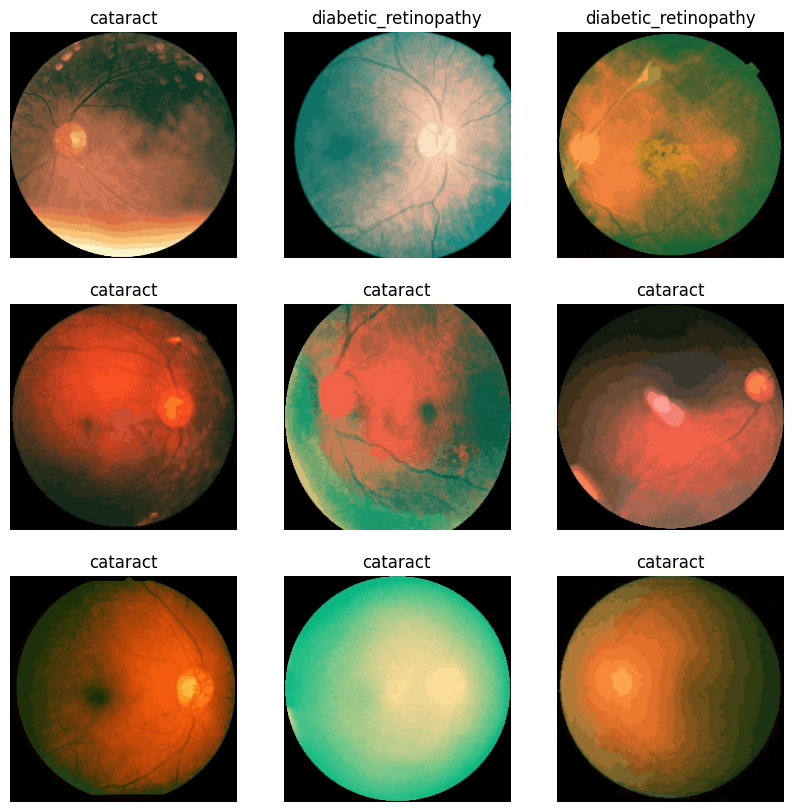

In [ ]:
plt.figure(figsize=(10, 10))

df = val_ds.take(1)

for images, labels in df:
    pred = clf.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

# RESNET50

In [ ]:
base_model1 = ResNet50(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights="imagenet",
)

base_model1.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
clf_rest = Sequential(name='eye_disease')

clf_rest.add(base_model1)
clf_rest.add(GlobalAveragePooling2D(name='Pooling'))
clf_rest.add(Dense(50, activation="relu", name='Dense_1'))
clf_rest.add(Dense(10, activation="relu", name='Dense_2'))
clf_rest.add(Dense(len(class_names), activation="softmax", name='Dense_out'))

clf_rest.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["acc",tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

clf_rest.summary()

Model: "eye_disease"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 Pooling (GlobalAveragePooli  (None, 2048)             0         
 ng2D)                                                           
                                                                 
 Dense_1 (Dense)             (None, 50)                102450    
                                                                 
 Dense_2 (Dense)             (None, 10)                510       
                                                                 
 Dense_out (Dense)           (None, 4)                 44        
                                                                 
Total params: 23,690,716
Trainable params: 23,637,596
Non-trainable params: 53,120
______________________________________

In [ ]:
with tf.device('/device:GPU:0'):
    history = clf_rest.fit(train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks = my_callbacks
    )

Epoch 1/10
106/106 [==============================] - 2868s 27s/step - loss: 0.6802 - acc: 0.7312 - precision: 0.8007 - recall: 0.6538 - val_loss: 9.3374 - val_acc: 0.3630 - val_precision: 0.3627 - val_recall: 0.3618
Epoch 2/10
106/106 [==============================] - 2708s 26s/step - loss: 0.4262 - acc: 0.8361 - precision: 0.8593 - recall: 0.8088 - val_loss: 1.6582 - val_acc: 0.6429 - val_precision: 0.6641 - val_recall: 0.6192
Epoch 3/10
106/106 [==============================] - 2722s 26s/step - loss: 0.3492 - acc: 0.8634 - precision: 0.8830 - recall: 0.8477 - val_loss: 1.1451 - val_acc: 0.6856 - val_precision: 0.6970 - val_recall: 0.6441
Epoch 4/10
106/106 [==============================] - 2774s 26s/step - loss: 0.3179 - acc: 0.8705 - precision: 0.8839 - recall: 0.8530 - val_loss: 0.3228 - val_acc: 0.8814 - val_precision: 0.9015 - val_recall: 0.8683
Epoch 5/10
106/106 [==============================] - 2822s 27s/step - loss: 0.2855 - acc: 0.8862 - precision: 0.8953 - recall: 0.87

In [ ]:
y_true_rest = list()
y_pred_rest = list()

for images, labels in train_ds:
    pred = clf_rest.predict(images)
    for i in range(len(pred)):
        y_true_rest.append(labels[i].numpy())
        y_pred_rest.append((pred[i] == pred[i].max()).astype(int))

y_true_rest = np.array(y_true_rest)
y_pred_rest = np.array(y_pred_rest)
y_true_rest, y_pred_rest

1/1 [==============================] - 4s 4s/step


(array([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]], dtype=float32), array([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        ...,
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1]]))

In [ ]:
print(classification_report(y_true_rest,y_pred_rest,target_names=list(class_names)))

                      precision    recall  f1-score   support

            cataract       0.73      0.94      0.82       836
diabetic_retinopathy       1.00      0.90      0.95       884
            glaucoma       0.81      0.62      0.70       802
              normal       0.77      0.80      0.79       852

           micro avg       0.82      0.82      0.82      3374
           macro avg       0.83      0.82      0.82      3374
        weighted avg       0.83      0.82      0.82      3374
         samples avg       0.82      0.82      0.82      3374



1/1 [==============================] - 5s 5s/step


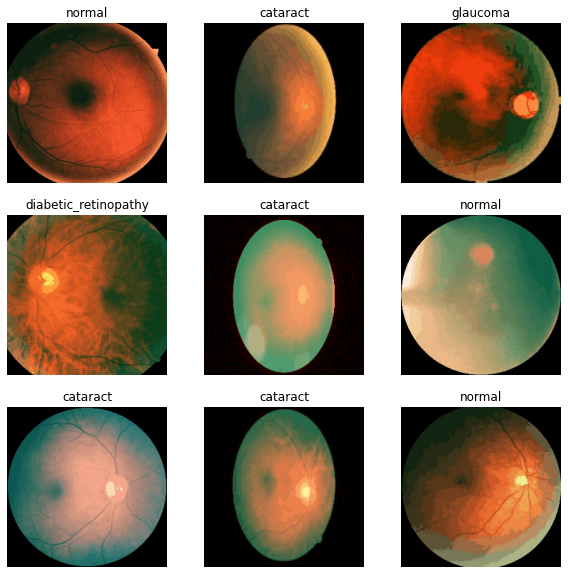

In [ ]:
plt.figure(figsize=(10, 10))

df_rest = train_ds.take(1)

for images, labels in df_rest:
    pred = clf_rest.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

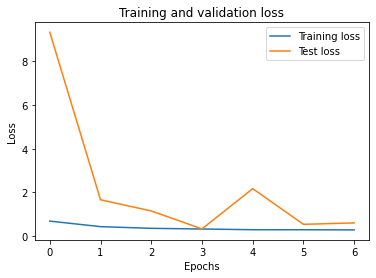

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

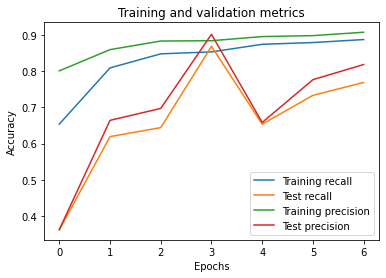

In [ ]:
plt.plot(history.history['recall'], label='Training recall')
plt.plot(history.history['val_recall'], label='Test recall')
plt.plot(history.history['precision'], label='Training precision')
plt.plot(history.history['val_precision'], label='Test precision')
plt.title('Training and validation metrics')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_true_rest = list()
y_pred_rest = list()

for images, labels in val_ds:
    pred = clf_rest.predict(images)
    for i in range(len(pred)):
        y_true_rest.append(labels[i].numpy())
        y_pred_rest.append((pred[i] == pred[i].max()).astype(int))

y_true_rest = np.array(y_true_rest)
y_pred_rest = np.array(y_pred_rest)
y_true_rest, y_pred_rest

1/1 [==============================] - 2s 2s/step


(array([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.]], dtype=float32), array([[0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        ...,
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0]]))

1/1 [==============================] - 6s 6s/step


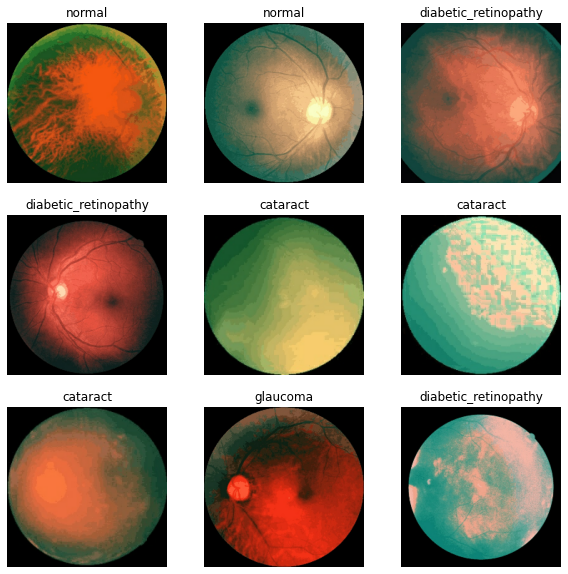

In [ ]:
plt.figure(figsize=(10, 10))

df_rest = val_ds.take(1)

for images, labels in df_rest:
    pred = clf_rest.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")